In [1]:
from utils import *

set_cache_dir('pickles/slides4')

ERROR 1: PROJ: proj_create_from_database: Open of /home/arthur/miniforge3/envs/climada_env/share/proj failed


# Estimation of return periods and return levels

<div class="alert alert-block alert-info">
<b>Our objectives:</b> 
<p>
<ul>
    <li>Express the return period in terms of the CDF of annual maxima</li>
    <li>Apply the non-parametric formula for the return period</li>
    <li>State the steps of the parametric approach corresponding to fitting a parametric distribution for annual maxima</li>
    <li>Express the return period formula in the case of granular-event data</li>
</ul>
</p>
</div>

In [2]:
import numpy as np
np.set_printoptions(precision=2)
np.random.seed(1712)

## Annual Maxima Data 

We will investigate two types of data that are common in practice:
1. Annual maxima data: this corresponds to the case where the available data is that of annual maxima of intensity
2. Granular event data: this corresponds to the case where we have granular data for unique events in terms of their intensity and time of occurence

We start by discussing the first case.

## Objective

Consider the situation where we have annual maxima data as per the following figure:

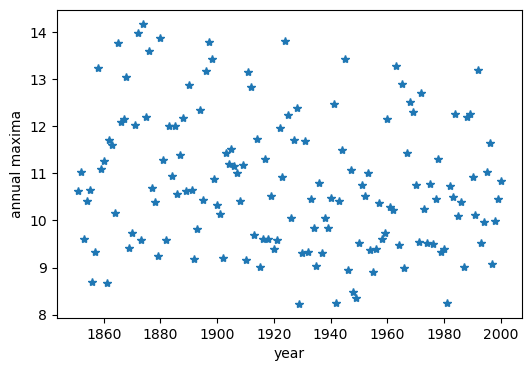

In [4]:
from scipy.stats import genextreme
import pandas as pd

# Parameters for the GEV distribution
c = 0  # shape parameter
loc = 10  # location parameter
scale = 1.1  # scale parameter

# Create a GEV distribution object
gev = genextreme(c, loc=loc, scale=scale)

# Generate random samples from the GEV distribution
samples = gev.rvs(size=150)
dates = pd.date_range('1850-01-01', '2000-01-01', freq='Y')

xs = np.linspace(7, 15, 100)
# Calculate the probability density function (PDF)
pdf_values = gev.pdf(xs)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(dates, samples, '*')
plt.xlabel('year')
plt.ylabel('annual maxima')
plt.show()

Our question: what is the return period for an event of intensity 12? 13? 14?

### Return period

<div class="alert alert-block alert-success">
<b>Definition:</b> For a given intensity $I$, the return period is the period T expressed in years such that the probability of observing an event with intensity greater than $I$ in a given year is $\frac{1}{T}$.

<p>An event with a Return Period $T$ is called a T-year event. For instance, we will say "a 100-year flood".</p>

<p>Another interpretation of the return period is that it is the expected number of years until an event
of a given intensity.</p>
</div>

Given this definition, if we define the annual maximum intensity as the random variable $X$, the
return period $T$ for an intensity $x$ is such that,

\begin{equation}
    \mathbb{P}(X\geq x) = \frac{1}{T}.
\end{equation}

As such, it is obvious that the return period should be a *non-decreasing* function of the intensity.

The previous formula can be written in terms of the Cumulative Distribution Function of the random variable $X$ (annual maximum),
$\frac{1}{T} = 1 - F_X(x)$, which leads to the following general formula:

<div class="alert alert-block alert-info">
<b>Proposition:</b> The return period $T(x)$ corresponding to an intensity level $x$ can be expressed in terms of the CDF of the annual maximum random variable according to,
    \begin{equation}
        T(x) = \frac{1}{1 - F_X(x)}.
    \end{equation}
</div>

Exercise: invert this formula to express the return level corresponding to a given return period, in terms of the Inverse Cumulative Distribution Function of $X$.

To estimate the return period from annual maxima data, we can use this formula by replacing $F_X(x)$ by an estimate of the cumulative distribution function of $X$.
We can distinguish two approaches:
1. Non-parametric: we will use a non-parametric estimator such as the empirical distribution function, or a Kernel Density Estimate.
2. Parametric: we will use a parametric estimator by specifying a parametric distribution for the annual maxima.

## Non-parametric approach - case 1: Empirical Distribution Function

We start with a non-parametric approach that relies on the *Empirical Distribution Function*, defined as,
\begin{equation}
    \widehat{F}_X(x) = \frac{1}{n + 1}\sum_{i=1}^{n}\mathbb{1}_{\geq x_i}(x),
\end{equation}
where $n$ is the number of years and the $x_i$'s are the annual maxima from our dataset, and the function $\mathbb{1}_{\geq x_i}$ is defined by,
\begin{equation}
    \mathbb{1}_{\geq x_i}(x)
    =
    \begin{cases}
        0 &\text{if } x< x_i,\\
        1 &\text{if } x\geq x_i.
    \end{cases}
\end{equation}

Note that usually, the normalization of the ECDF uses the factor $\frac{1}{n}$, however for extreme-values it is common to instead use $\frac{1}{n + 1}$ as per the formula above.

ADD INTERACTIVE FIGURE FOR ECDF.

If we replace $F_X$ by this estimate, we obtain the following simple formula:

\begin{equation}
    T(x_{(i)}) = \frac{n+1}{i},
\end{equation}
where the $x_{(i)}$'s (notice the bracket in the notation) are obtained by sorting the values of the $x_i$'s (without bracket in the notation, the original data) in decreasing order. For instance,
if $x_1=5, x_2=3, x_4=7, x_5=6$, what are the $x_{(i)}'s$? What is the return period for intensity 5?

## Non-parametric approach - case 2: Kernel Density Estimation

## Parametric approach

We now consider the parametric approach. The general idea is to fit a parametric distribution to the data of annual maxima and to use the
ECDF of that fitted distribution in the general formula for the return period from annual maxima.

In particular, a standard distribution for annual maxima is the *General Extreme Value* distribution, whose Cumulative Distribution Function is
given by,

\begin{equation}
    F_X(x; \mu, \sigma, \xi) =
    \begin{cases}
        \exp(-\exp(-s)) & \text{if $\xi=0$ (Gumbell distribution)},\\
        \exp(-(1 + \xi s)^{-1/\xi} & \text{if $\xi\neq 0$ (Fréchet or Weibull distribution)}.
    \end{cases}
\end{equation}

The idea is therefore to obtain estimates $\hat{\mu}, \hat{\sigma}$ and $\hat{\xi}$ of the parameters $\mu, \sigma, \xi$, respectively, and to then
plug-in the corresponding CDF $F_X(x;\hat{\mu}, \hat{\sigma},\hat{\xi})$ into our general formula:

\begin{equation}
    T(x) = \frac{1}{1 - F_X(x;\hat{\mu}, \hat{\sigma},\hat{\xi})}.
\end{equation}

In [5]:
import numpy as np

def neg_log_likelihood_gev(samples, theta):
    loc, scale = theta
    c = 0
    gev = genextreme(0., loc=loc, scale=scale)
    out = np.mean(gev.logpdf(samples))
    if not np.isfinite(out):
        return np.inf
    return -out

In [6]:
from scipy.optimize import minimize

x0=[8., 0.8]
opt = minimize(lambda x: neg_log_likelihood_gev(samples, x), 
         x0=x0, 
         #bounds=[(5, 15), (0, 2)],
         #callback=lambda *args, **kwargs: print(*args, neg_log_likelihood_gev(samples, args[0])),
         method='CG',
        )
opt

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.748359285180638
       x: [ 1.013e+01  1.204e+00]
     nit: 15
     jac: [ 4.649e-06  3.234e-06]
    nfev: 63
    njev: 21

In [7]:
fitted = opt.x

In [8]:
def return_period(intensity, gev_params):
    loc, scale = gev_params
    gev = genextreme(0, loc=loc, scale=scale)
    return 1 / (1 - gev.cdf(intensity))

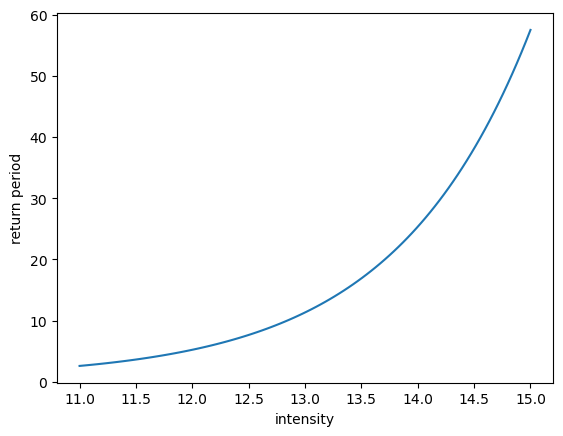

In [9]:
intensities = np.linspace(11, 15, 100)
rps = return_period(intensities, fitted)

plt.figure()
plt.plot(intensities, rps)
plt.xlabel('intensity')
plt.ylabel('return period')

plt.savefig('rpplot1.jpg')

## Granular-event data

Another approach might consist in using granular-event data, that is to say data where for every unique event we have a time of occurence and 
an intensity. For instance, in the case of the tropical cyclone data, we have access to granular data.

Text(0, 0.5, 'intensity')

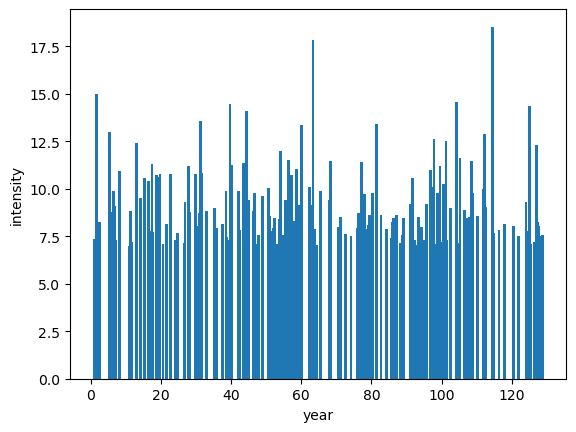

In [11]:
from scipy.stats import expon
from datetime import datetime, timedelta

dist_intervals = expon(scale=0.7)
dist_intensities = expon(loc=7, scale=2)

n_points = 200
time_intervals = dist_intervals.rvs(n_points)
times = np.cumsum(time_intervals)
intensities = dist_intensities.rvs(n_points)

date_start = datetime(1850, 1, 1)

plt.figure()
plt.bar(times, intensities)
plt.xlabel('year')
plt.ylabel('intensity')

Here the data consists of tuples $(T_i, X_i)$ where $T_i$ is the time of occurence of the $i$'th event and $X_i$ is the magnitude of the event.

We can model this via two independent distribution:
1. A distribution for the number of events per unit of time (e.g. 1 year)
2. A distribution for the magnitudes of the events

If we denote the expected number of events per year (i.e. frequency) by $\lambda$, then the return period can be expressed as,

\begin{equation}
    T(x) = \frac{1}{\lambda \left(1 - F_X(x)\right)}.
\end{equation}

<div class="alert alert-block alert-danger">
<b>Note that this formula is similar yet *very different* from the one for annual maxima data:</b> 
<ul>
    <li>We need to account for the frequency of the events, $\lambda$,</li>
    <li>$F_X$ is the Cumulative Distribution Function of the magnitude of individual events, whereas in the previous formula it was the CDF of the annual maxima.</li>
</div>

As for annual maxima data, we can use two types of approaches for estimation: non-parametric and parametric.